# Fitting models in botorch with a torch.optim.Optimizer
botorch also provides a convenient `botorch.fit.fit_model` function with sensible defaults that work on most basic models. This tutorial allows you to customize model fitting to your needs using the familiar PyTorch-style model fitting loop.

This tutorial is adapted from GPyTorch's [Simple GP Regression Tutorial](https://github.com/cornellius-gp/gpytorch/blob/master/examples/01_Simple_GP_Regression/Simple_GP_Regression.ipynb) and has very few changes because the out-of-the box models that botorch provides are GPyTorch models; in fact, they are proper subclasses that add the `botorch.models.Model` and `botorch.posterior.Posterior` API functions.

In [25]:
import math
import torch
from matplotlib import pyplot as plt

In [26]:
dtype = torch.float
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Set up function to model
In this tutorial we will model a simple sinusoidal function with i.i.d. Gaussian noise:
$$y = \sin(2\pi x) + \epsilon, ~\epsilon \sim \mathcal N(0,0.1)$$

### Initialize training data

In [71]:
# use regular spaced points on the interval [0, 1]
train_X = torch.linspace(0, 1, 15, dtype=dtype, device=device)
# sample observed values
train_Y = torch.sin(train_X * (2 * math.pi)) + torch.randn_like(train_X) * 0.1

### Initialize model
We will model the function using a `botorch.models.SingleTaskGP`, which by default uses a `gpytorch.likelihoods.GaussianLikelihood` and infers the unknown noise level. 

In [82]:
from botorch.models import SingleTaskGP
model = SingleTaskGP(train_X=train_X, train_Y=train_Y)

### Define marginal log likelihood 
We will optimizing the the kernel hyperparameters and the likelihood's noise parameter jointly by minimizing the negative `gpytorch.mlls.ExactMarginalLogLikelihood` (our loss function).

In [83]:
from gpytorch.mlls import ExactMarginalLogLikelihood
mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
# set mll and all submodules (model, likelihood) to the specified dtype and device
mll = mll.to(dtype=dtype, device=device)

### Define optimizer and specify parameters to optimize
We will use stochastic gradient descent (`torch.optim.SGD`) to optimize the kernel hyperparameters and the noise level. In this example, we will use a learning rate of 0.1, but in practice the learning may need to adjusted.

Note: The `GaussianLikelihood` module is a of child (submodule) of the `SingleTaskGP` object, so `model.parameters()` will include the parameters (noise level) of the `GaussianLikelihood`. 

Note: a subset of the parameters could be passed to the optimizer to tune those parameters, while leaving the other parameters fixed.

In [84]:
from torch.optim import SGD
optimizer = SGD([{'params': model.parameters()}], lr=0.1)

### Fit model hyperparameters and noise level
Now we are ready to write our optimization loop. We will perform 100 epochs of stochastic gradient descent using our entire training set.

In [85]:
NUM_EPOCHS = 100

model.train()
model.likelihood.train()

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = model(train_X)
    # Compute negative marginal log likelihood
    loss = -mll(output, train_Y)
    # back prop gradients
    loss.backward()
    print(
        f"Epoch {epoch + 1}/{NUM_EPOCHS} - Loss:{round(loss.item(),3)} "
        f"lengthscale: {round(model.covar_module.base_kernel.lengthscale.item(), 3)} " 
        f" noise: {round(model.likelihood.noise.item(),3)}" 
     )
    optimizer.step()

Epoch 1/100 - Loss:1.534 lengthscale: 0.693  noise: 0.693
Epoch 2/100 - Loss:1.527 lengthscale: 0.688  noise: 0.682
Epoch 3/100 - Loss:1.518 lengthscale: 0.681  noise: 0.669
Epoch 4/100 - Loss:1.51 lengthscale: 0.673  noise: 0.657
Epoch 5/100 - Loss:1.501 lengthscale: 0.666  noise: 0.645
Epoch 6/100 - Loss:1.492 lengthscale: 0.659  noise: 0.633
Epoch 7/100 - Loss:1.485 lengthscale: 0.653  noise: 0.622
Epoch 8/100 - Loss:1.477 lengthscale: 0.646  noise: 0.611
Epoch 9/100 - Loss:1.468 lengthscale: 0.639  noise: 0.599
Epoch 10/100 - Loss:1.46 lengthscale: 0.633  noise: 0.588
Epoch 11/100 - Loss:1.452 lengthscale: 0.627  noise: 0.577
Epoch 12/100 - Loss:1.443 lengthscale: 0.62  noise: 0.565
Epoch 13/100 - Loss:1.435 lengthscale: 0.614  noise: 0.555
Epoch 14/100 - Loss:1.427 lengthscale: 0.608  noise: 0.545
Epoch 15/100 - Loss:1.419 lengthscale: 0.602  noise: 0.535
Epoch 16/100 - Loss:1.41 lengthscale: 0.596  noise: 0.524
Epoch 17/100 - Loss:1.401 lengthscale: 0.589  noise: 0.513
Epoch 18/1

### Compute posterior over test points and plot fit
We plot the posterior mean and the 2 standard deviations from the mean.

In [86]:
# set model and likelihood to eval mode
model.eval()
model.likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (noise_prior): GammaPrior()
  )
)

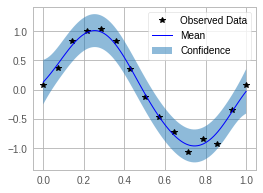

In [87]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(0, 1, 101, dtype=dtype, device=device)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'k*')
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])